In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

In [3]:
blast_cutoffs = ['30', '40', '50', '70', '90', '95', '100', 'None']
core_sets = ['2007', '2013', '2016', 'all']
pdbbind_releases = [2013, 2014, 2015, 2016, 2017, 2018]
refined_sets = [f'{year} refined' for year in pdbbind_releases]
general_sets = [f'{year} general' for year in pdbbind_releases]
data_sets = refined_sets + general_sets
scoring_functions = ['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']
feature_sets = ['RDKit', 'Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0', 'Vina + RDKit', 'RF-Score + RDKit', 'RF-Score v3 + RDKit', 'NNScore 2.0 + RDKit']

In [4]:
with open('../results/varying_seqid_cutoff_test_results.json', 'r') as f:
    test_rps = json.load(f)

In [5]:
with open('../results/varying_seqid_cutoff_oob_results.json', 'r') as f:
    oob_rps = json.load(f)

In [6]:
with open('../data/training_sets_varying_cutoff.json', 'r') as f:
    training_sets = json.load(f)

In [7]:
general_training_set_size = pd.DataFrame({y: {c: len(training_sets[f'{y} general'][c]['all']) for c in blast_cutoffs} for y in pdbbind_releases}).loc[blast_cutoffs]
refined_training_set_size = pd.DataFrame({y: {c: len(training_sets[f'{y} refined'][c]['all']) for c in blast_cutoffs} for y in pdbbind_releases}).loc[blast_cutoffs]

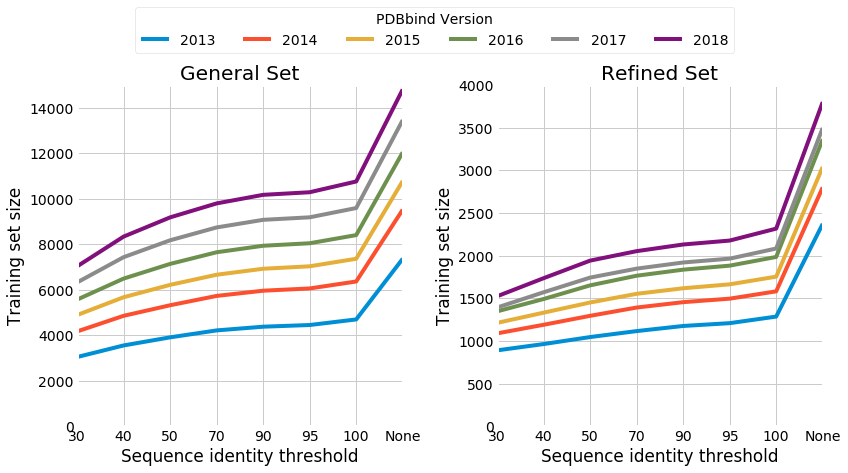

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
general_training_set_size.plot(ax=ax1, legend=False)
ax1.set_xlabel('Sequence identity threshold')
ax1.set_ylabel('Training set size')
ax1.set_title('General Set')
ax1.set_ylim(0, 15000)

refined_training_set_size.plot(ax=ax2, legend=False)
#ax.legend(title='Refined set version')
ax2.set_xlabel('Sequence identity threshold')
ax2.set_ylabel('Training set size')
ax2.set_title('Refined Set')
ax2.set_ylim(0, 4000)
fig.tight_layout()
ax2.legend(title='PDBbind Version', ncol=6, bbox_to_anchor=(0.75, 1.25))

fig.savefig('../figures/training_set_size.jpg', dpi=350, bbox_inches='tight')
fig.savefig('../figures/training_set_size.eps', dpi=350, bbox_inches='tight')

Build dicts of dataframes of Pearson correlation coefficients on each CASF benchmark set. The dataframes in the first dictionary record the Pearson correlation coefficient obtained using each feature set and each training set at a given sequence identity cutoff for training-test protein similarity. The dataframes in the second dictionary instead record the Pearson correlation coefficient obtained using each feature set and each sequence identity cutoff for a given training set.

In [8]:
oob_rp_by_year = {}
for core_set in core_sets:
    oob_rp_by_year[core_set] = {}
    for cutoff in blast_cutoffs:
        oob_rp_by_year[core_set][cutoff] = pd.DataFrame.from_dict({data_set: {feature_set: oob_rps[cutoff][data_set][feature_set][core_set] for feature_set in feature_sets} for data_set in data_sets})

oob_rp_by_cutoff = {}
for core_set in core_sets:
    oob_rp_by_cutoff[core_set] = {}
    for data_set in data_sets:
        oob_rp_by_cutoff[core_set][data_set] = pd.DataFrame.from_dict({cutoff: {feature_set: oob_rps[cutoff][data_set][feature_set][core_set] for feature_set in feature_sets} for cutoff in blast_cutoffs})

In [9]:
rp_by_year = {}
for core_set in core_sets:
    rp_by_year[core_set] = {}
    for cutoff in blast_cutoffs:
        rp_by_year[core_set][cutoff] = pd.DataFrame.from_dict({data_set: {feature_set: test_rps[cutoff][data_set][feature_set][core_set] for feature_set in feature_sets} for data_set in data_sets})

rp_by_cutoff = {}
for core_set in core_sets:
    rp_by_cutoff[core_set] = {}
    for data_set in data_sets:
        rp_by_cutoff[core_set][data_set] = pd.DataFrame.from_dict({cutoff: {feature_set: test_rps[cutoff][data_set][feature_set][core_set] for feature_set in feature_sets} for cutoff in blast_cutoffs})

List top performance attained by each SF on each test set

For each sequence identity cutoff, create plots of scoring function performance against PDBbind release year.

Now plot performance against cutoff for each PDBbind release year.

General set

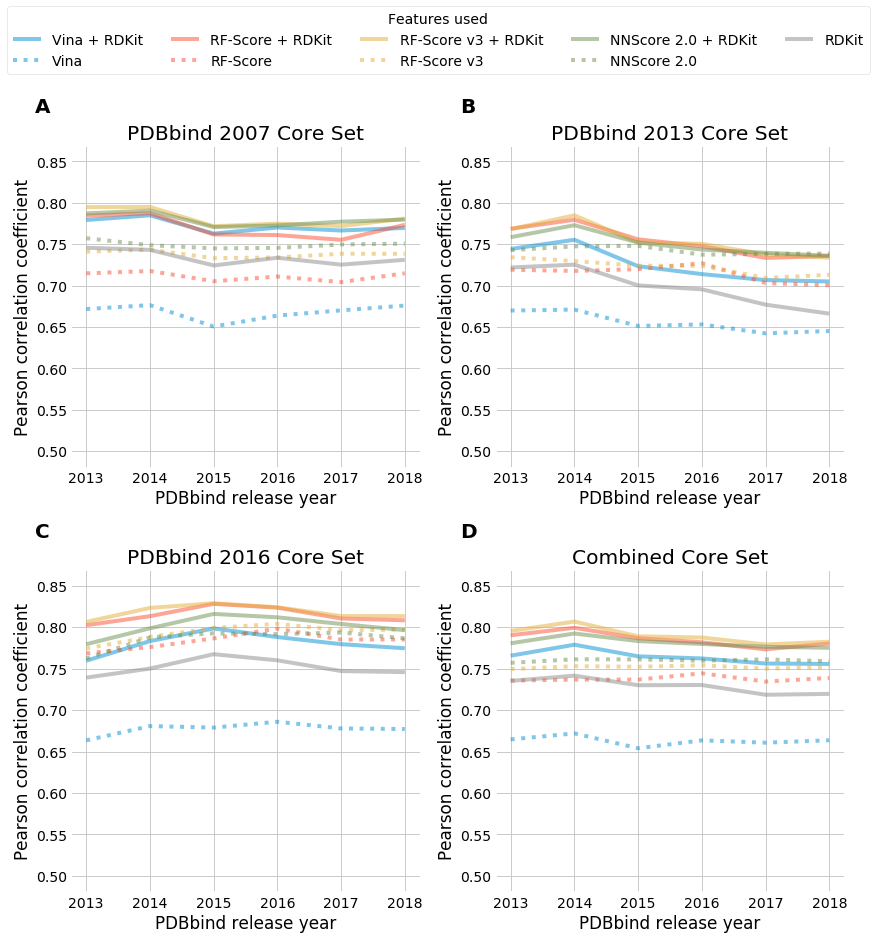

In [9]:
#%%capture
cutoff = 'None'

#fig, axes = plt.subplots(2, 2, figsize=(16, 16))#, sharex=True, sharey=True)
fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.flatten()
x = pdbbind_releases

for core_set, ax in zip(['2007', '2013', '2016', 'all'], axes):#.flatten()):

    colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

    # lines for structure-based scoring functions
    for sf in scoring_functions:
        colour = next(colours)
        y = rp_by_year[core_set][cutoff].loc[sf + ' + RDKit', refined_sets]
        ax.plot(x, y, alpha=0.5, color=colour)
        y = rp_by_year[core_set][cutoff].loc[sf, refined_sets]
        ax.plot(x, y, alpha=0.5, color=colour, linestyle=':')

    # add a line for L-BAP
    colour = next(colours)
    y = rp_by_year[core_set][cutoff].loc['RDKit', refined_sets]
    ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
    if core_set == 'all':
        ax.set_title('Combined Core Set')
    else:
        ax.set_title(f'PDBbind {core_set} Core Set')
    ax.set_ylim(0.48, 0.87)
    ax.set_xlabel('PDBbind release year')
    ax.set_ylabel('Pearson correlation coefficient')

for ax, annotation in zip(axes, ['A', 'B', 'C', 'D']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
fig.tight_layout()
axes[0].legend(title='Features used', loc='upper left', bbox_to_anchor=(-0.2, 1.45),ncol=5)
fig.savefig('../figures/pearsonr_refined_set_no_cutoff.jpg', dpi=350, bbox_inches='tight')

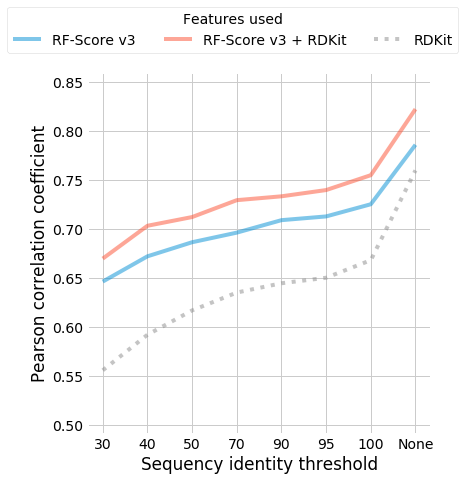

In [28]:
# plot for ISMB abstract

#%%capture
year = '2018'

#fig, axes = plt.subplots(2, 2, figsize=(16, 16))#, sharex=True, sharey=True)

fig, ax = plt.subplots(1,1, figsize=(6,6))
x = blast_cutoffs

core_set = 'all'
colours = plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]


# lines for structure-based scoring functions
sf = 'RF-Score v3'
colour = colours[0]
y = rp_by_cutoff[core_set][f'{year} general'].loc[sf, blast_cutoffs]
ax.plot(x, y, alpha=0.5, label=sf, color=colour)
colour = colours[1]
y = rp_by_cutoff[core_set][f'{year} general'].loc[sf + ' + RDKit', blast_cutoffs]
ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)

# add a line for L-BAP
colour = colours[-1]
y = rp_by_cutoff[core_set][f'{year} general'].loc['RDKit', blast_cutoffs]
ax.plot(x, y, alpha=0.5, label='RDKit', color=colour, linestyle=':')

ax.set_ylim(0.49, 0.86)
ax.set_xlabel('Sequency identity threshold')
ax.set_ylabel('Pearson correlation coefficient')

fig.tight_layout()
ax.legend(bbox_to_anchor=(1.1, 1.2),ncol=3, title='Features used')
fig.savefig(f'../figures/rfv3_rdk_summary_plot.eps', dpi=350, bbox_inches='tight')

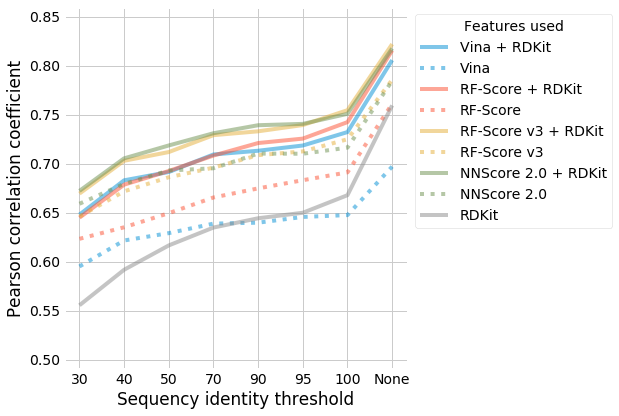

In [25]:
# plot for ISMB abstract

#%%capture
year = '2018'

#fig, axes = plt.subplots(2, 2, figsize=(16, 16))#, sharex=True, sharey=True)

fig, ax = plt.subplots(1,1, figsize=(6,6))
x = blast_cutoffs

core_set = 'all'
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])


# lines for structure-based scoring functions
for sf in scoring_functions:
    colour = next(colours)
    y = rp_by_cutoff[core_set][f'{year} general'].loc[sf + ' + RDKit', blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_cutoff[core_set][f'{year} general'].loc[sf, blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')

# add a line for L-BAP
colour = next(colours)
y = rp_by_cutoff[core_set][f'{year} general'].loc['RDKit', blast_cutoffs]
ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)

ax.set_ylim(0.49, 0.86)
ax.set_xlabel('Sequency identity threshold')
ax.set_ylabel('Pearson correlation coefficient')

fig.tight_layout()
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0),ncol=1, title='Features used')
fig.savefig(f'../figures/general_combined_core_set_varyiny_si_cutoff.jpg', dpi=350, bbox_inches='tight')
fig.savefig(f'../figures/general_combined_core_set_varyiny_si_cutoff.eps', dpi=350, bbox_inches='tight')

# OOB and combined core set performance when training on 2018 refined

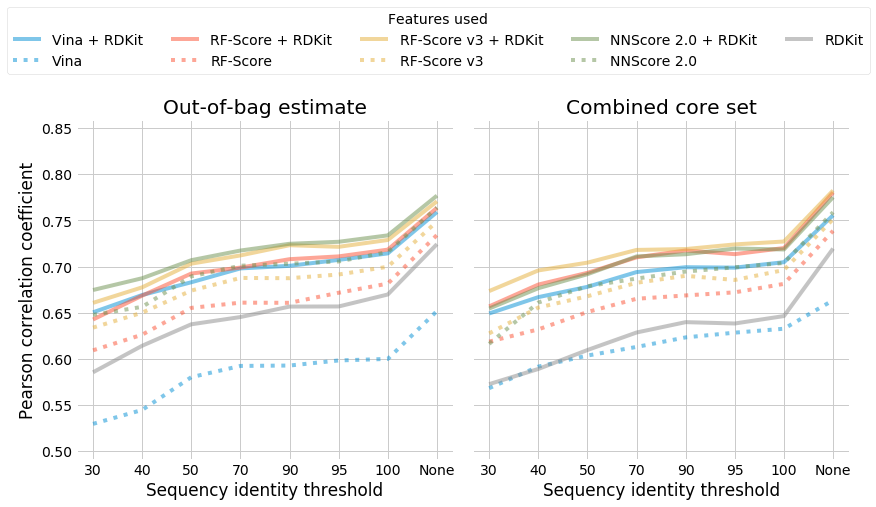

In [13]:
#%%capture
year = '2018'

#fig, axes = plt.subplots(2, 2, figsize=(16, 16))#, sharex=True, sharey=True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)
x = blast_cutoffs

core_set = 'all'
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])


# lines for structure-based scoring functions
for sf in scoring_functions:
    colour = next(colours)
    y = oob_rp_by_cutoff[core_set][f'{year} refined'].loc[sf + ' + RDKit', blast_cutoffs]
    ax1.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = oob_rp_by_cutoff[core_set][f'{year} refined'].loc[sf, blast_cutoffs]
    ax1.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')
    
    y = rp_by_cutoff[core_set][f'{year} refined'].loc[sf + ' + RDKit', blast_cutoffs]
    ax2.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_cutoff[core_set][f'{year} refined'].loc[sf, blast_cutoffs]
    ax2.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')

# add a line for L-BAP
colour = next(colours)
y = oob_rp_by_cutoff[core_set][f'{year} refined'].loc['RDKit', blast_cutoffs]
ax1.plot(x, y, alpha=0.5, label='RDKit', color=colour)
y = rp_by_cutoff[core_set][f'{year} refined'].loc['RDKit', blast_cutoffs]
ax2.plot(x, y, alpha=0.5, label='RDKit', color=colour)

ax1.set_title('Out-of-bag estimate')
ax2.set_title('Combined core set')

ax1.set_ylim(0.49, 0.86)
ax1.set_xlabel('Sequency identity threshold')
ax2.set_xlabel('Sequency identity threshold')

ax1.set_ylabel('Pearson correlation coefficient')

fig.tight_layout()
ax1.legend(loc='upper left', bbox_to_anchor=(-0.2, 1.35),ncol=5, title='Features used')
fig.savefig(f'../figures/2018_refined_summary_plot.jpg', dpi=350, bbox_inches='tight')
fig.savefig(f'../figures/2018_refined_summary_plot.eps', dpi=350, bbox_inches='tight')

# OOB and combined core set performance when training on 2018 general

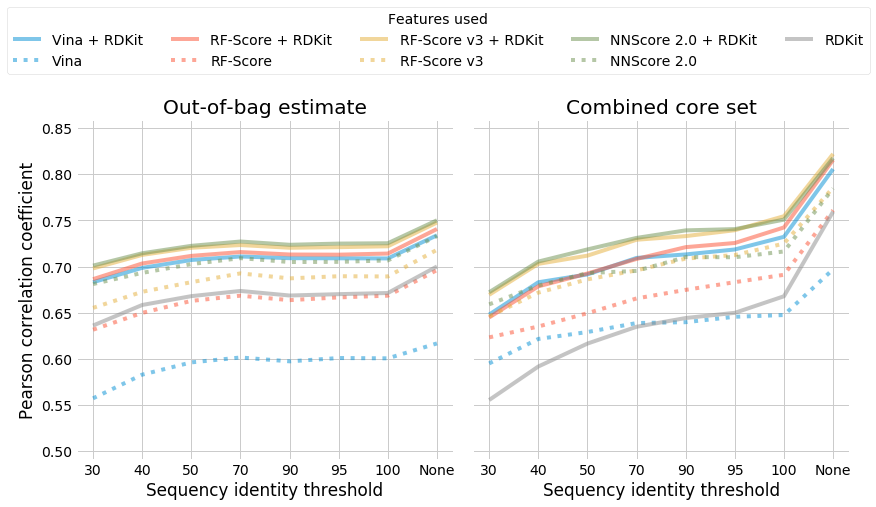

In [14]:
#%%capture
year = '2018 general'

#fig, axes = plt.subplots(2, 2, figsize=(16, 16))#, sharex=True, sharey=True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)
x = blast_cutoffs

core_set = 'all'
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])


# lines for structure-based scoring functions
for sf in scoring_functions:
    colour = next(colours)
    y = oob_rp_by_cutoff[core_set][year].loc[sf + ' + RDKit', blast_cutoffs]
    ax1.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = oob_rp_by_cutoff[core_set][year].loc[sf, blast_cutoffs]
    ax1.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')
    
    y = rp_by_cutoff[core_set][year].loc[sf + ' + RDKit', blast_cutoffs]
    ax2.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_cutoff[core_set][year].loc[sf, blast_cutoffs]
    ax2.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')

# add a line for L-BAP
colour = next(colours)
y = oob_rp_by_cutoff[core_set][year].loc['RDKit', blast_cutoffs]
ax1.plot(x, y, alpha=0.5, label='RDKit', color=colour)
y = rp_by_cutoff[core_set][year].loc['RDKit', blast_cutoffs]
ax2.plot(x, y, alpha=0.5, label='RDKit', color=colour)

ax1.set_title('Out-of-bag estimate')
ax2.set_title('Combined core set')

ax1.set_ylim(0.49, 0.86)
ax1.set_xlabel('Sequency identity threshold')
ax2.set_xlabel('Sequency identity threshold')
ax1.set_ylabel('Pearson correlation coefficient')

fig.tight_layout()
ax1.legend(loc='upper left', bbox_to_anchor=(-0.2, 1.35),ncol=5, title='Features used')
fig.savefig(f'../figures/2018_general_summary_plot.jpg', dpi=350, bbox_inches='tight')
fig.savefig(f'../figures/2018_general_summary_plot.eps', dpi=350, bbox_inches='tight')

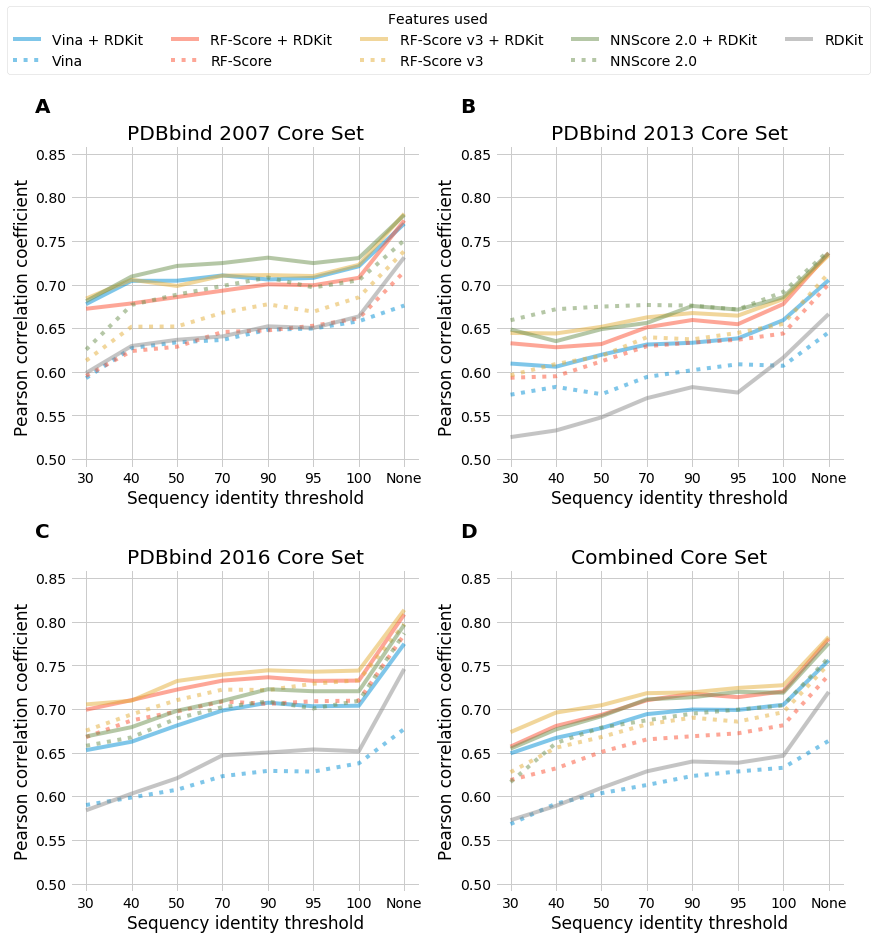

In [15]:
#%%capture
year = '2018'

#fig, axes = plt.subplots(2, 2, figsize=(16, 16))#, sharex=True, sharey=True)

fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.flatten()
x = blast_cutoffs

for core_set, ax in zip(['2007', '2013', '2016', 'all'], axes):
    colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

    # lines for structure-based scoring functions
    for sf in scoring_functions:
        colour = next(colours)
        y = rp_by_cutoff[core_set][f'{year} refined'].loc[sf + ' + RDKit', blast_cutoffs]
        ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
        y = rp_by_cutoff[core_set][f'{year} refined'].loc[sf, blast_cutoffs]
        ax.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')
        
    # add a line for L-BAP
    colour = next(colours)
    y = rp_by_cutoff[core_set][f'{year} refined'].loc['RDKit', blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
    if core_set == 'all':
        ax.set_title('Combined Core Set')
    else:
        ax.set_title(f'PDBbind {core_set} Core Set')
    ax.set_ylim(0.49, 0.86)
    ax.set_xlabel('Sequency identity threshold')
    ax.set_ylabel('Pearson correlation coefficient')

for ax, annotation in zip(axes, ['A', 'B', 'C', 'D']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
fig.tight_layout()
axes[0].legend(loc='upper left', bbox_to_anchor=(-0.2, 1.45),ncol=5, title='Features used')
fig.savefig(f'../figures/pearsonr_refined_set_2018.jpg', dpi=350, bbox_inches='tight')

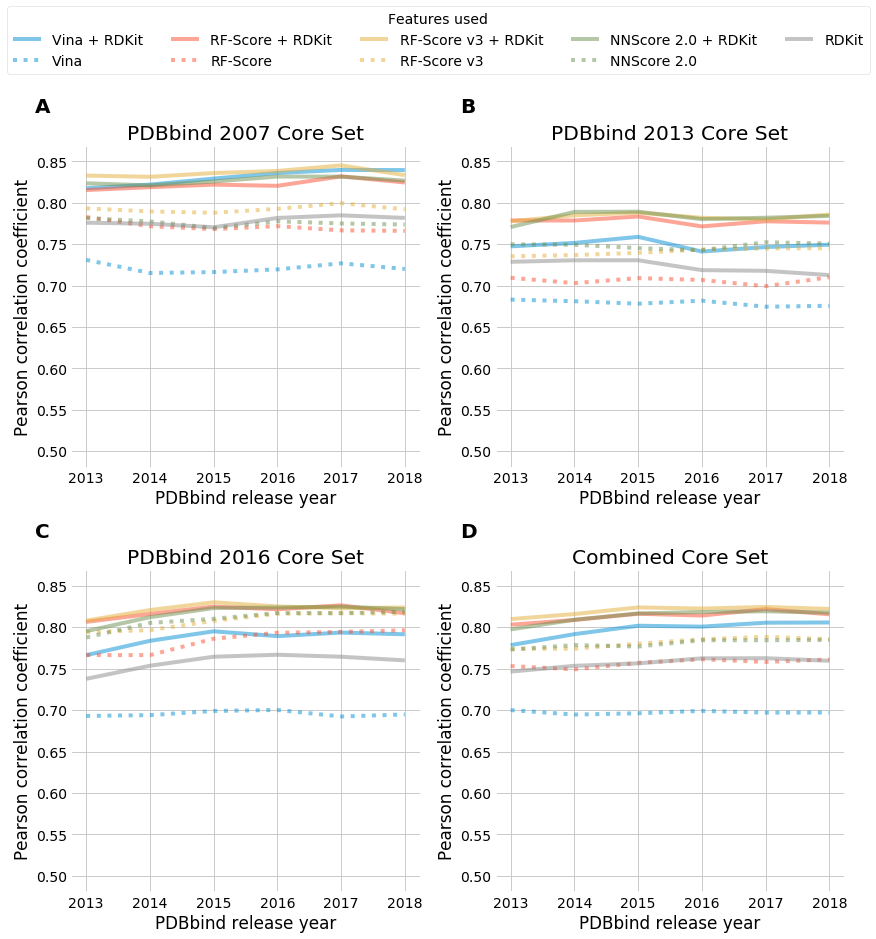

In [12]:
#%%capture
cutoff = 'None'

#fig, axes = plt.subplots(2, 2, figsize=(16, 16))#, sharex=True, sharey=True)
fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.flatten()
x = pdbbind_releases

for core_set, ax in zip(['2007', '2013', '2016', 'all'], axes):#.flatten()):

    colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

    # lines for structure-based scoring functions
    for sf in scoring_functions:
        colour = next(colours)
        y = rp_by_year[core_set][cutoff].loc[sf + ' + RDKit', general_sets]
        ax.plot(x, y, alpha=0.5, color=colour)
        y = rp_by_year[core_set][cutoff].loc[sf, general_sets]
        ax.plot(x, y, alpha=0.5, color=colour, linestyle=':')

    # add a line for L-BAP
    colour = next(colours)
    y = rp_by_year[core_set][cutoff].loc['RDKit', general_sets]
    ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
    if core_set == 'all':
        ax.set_title('Combined Core Set')
    else:    
        ax.set_title(f'PDBbind {core_set} Core Set')
    ax.set_ylim(0.48, 0.87)
    ax.set_xlabel('PDBbind release year')
    ax.set_ylabel('Pearson correlation coefficient')

for ax, annotation in zip(axes, ['A', 'B', 'C', 'D']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
fig.tight_layout()
axes[0].legend(title='Features used', loc='upper left', bbox_to_anchor=(-0.2, 1.45),ncol=5)
fig.savefig('../figures/pearsonr_general_set_no_cutoff.jpg', dpi=350, bbox_inches='tight')

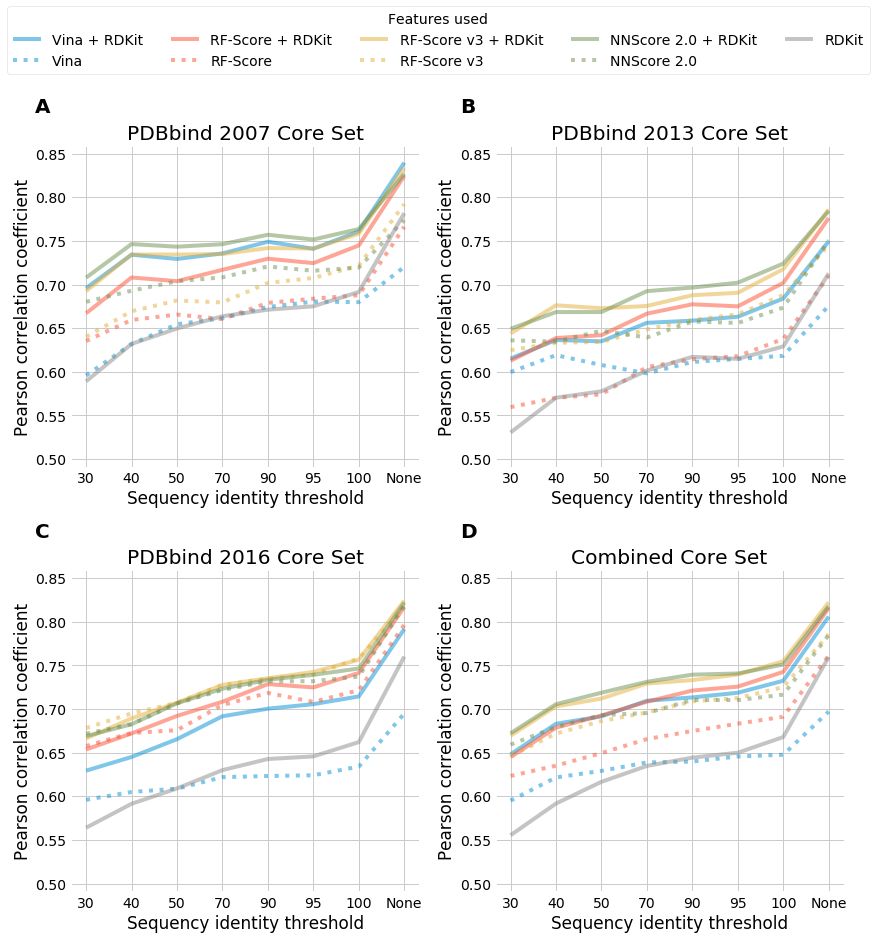

In [16]:
#%%capture
year = '2018'

#fig, axes = plt.subplots(2, 2, figsize=(16, 16))#, sharex=True, sharey=True)

fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.flatten()
x = blast_cutoffs

for core_set, ax in zip(['2007', '2013', '2016', 'all'], axes):
    colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

    # lines for structure-based scoring functions
    for sf in scoring_functions:
        colour = next(colours)
        y = rp_by_cutoff[core_set][f'{year} general'].loc[sf + ' + RDKit', blast_cutoffs]
        ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
        y = rp_by_cutoff[core_set][f'{year} general'].loc[sf, blast_cutoffs]
        ax.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')
        

    # add a line for L-BAP
    colour = next(colours)
    y = rp_by_cutoff[core_set][f'{year} general'].loc['RDKit', blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
    if core_set == 'all':
        ax.set_title('Combined Core Set')
    else:
        ax.set_title(f'PDBbind {core_set} Core Set')
    ax.set_ylim(0.49, 0.86)
    ax.set_xlabel('Sequency identity threshold')
    ax.set_ylabel('Pearson correlation coefficient')
    

for ax, annotation in zip(axes, ['A', 'B', 'C', 'D']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
fig.tight_layout()
axes[0].legend(loc='upper left', bbox_to_anchor=(-0.2, 1.45),ncol=5, title='Features used')
fig.savefig(f'../figures/pearsonr_general_set_2018.jpg', dpi=350, bbox_inches='tight')

# Summary figure for paper

In [18]:
with open('../results/varying_seqid_cutoff_similar_ligands_removed_test_results.json', 'r') as f:
    test_rps_lig = json.load(f)

rp_by_year_lig = {}
for core_set in core_sets:
    rp_by_year_lig[core_set] = {}
    for cutoff in blast_cutoffs:
        rp_by_year_lig[core_set][cutoff] = pd.DataFrame.from_dict({data_set: {feature_set: test_rps_lig[cutoff][data_set][feature_set][core_set] for feature_set in feature_sets} for data_set in data_sets})

rp_by_cutoff_lig = {}
for core_set in core_sets:
    rp_by_cutoff_lig[core_set] = {}
    for data_set in data_sets:
        rp_by_cutoff_lig[core_set][data_set] = pd.DataFrame.from_dict({cutoff: {feature_set: test_rps_lig[cutoff][data_set][feature_set][core_set] for feature_set in feature_sets} for cutoff in blast_cutoffs})

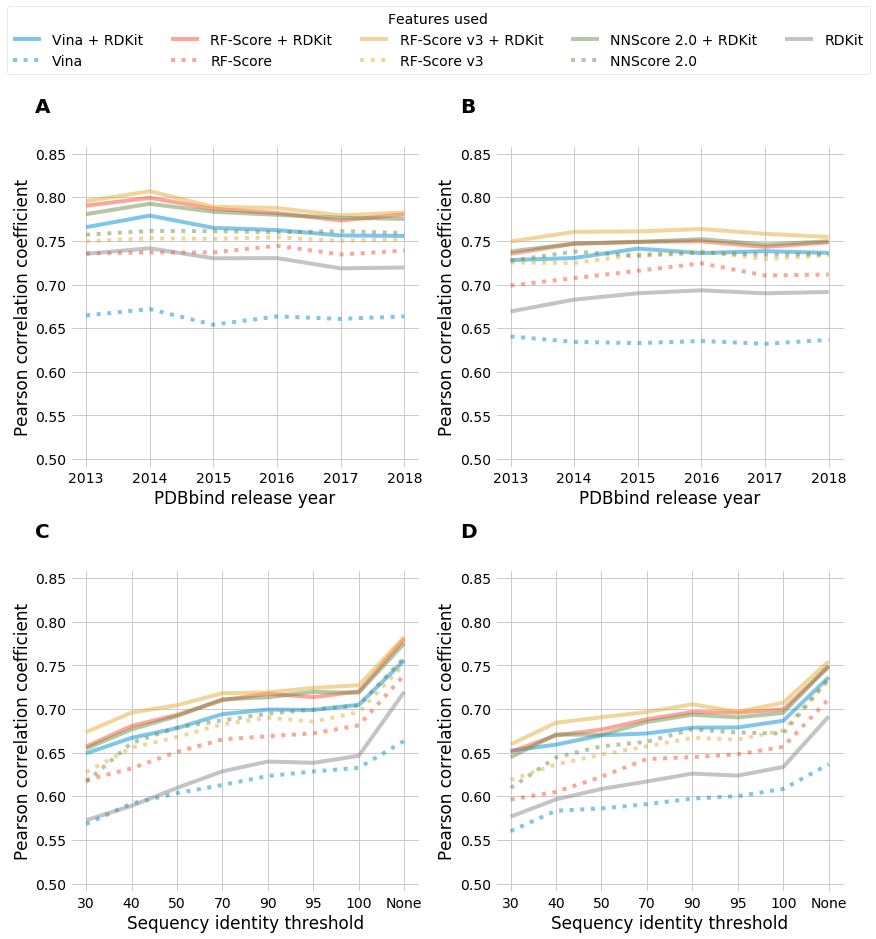

In [19]:
#%%capture
cutoff= 'None'
year = '2018'
core_set = 'all'
data_set = '2018 refined'


fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.flatten()
iteraxes = iter(axes)

# varying year
ax = next(iteraxes)
x = pdbbind_releases
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for sf in scoring_functions:
    colour = next(colours)
    y = rp_by_year[core_set][cutoff].loc[sf + ' + RDKit', refined_sets]
    ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_year[core_set][cutoff].loc[sf, refined_sets]
    ax.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')

colour = next(colours)
y = rp_by_year[core_set][cutoff].loc['RDKit', refined_sets]
ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
ax.set_ylim(0.49, 0.86)
ax.set_xlabel('PDBbind release year')
ax.set_ylabel('Pearson correlation coefficient')

# varying year; similar ligands excluded
ax = next(iteraxes)
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for sf in scoring_functions:
    colour = next(colours)
    y = rp_by_year_lig[core_set][cutoff].loc[sf + ' + RDKit', refined_sets]
    ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_year_lig[core_set][cutoff].loc[sf, refined_sets]
    ax.plot(x, y, alpha=0.5, label=sf, color=colour,linestyle=':')

colour = next(colours)
y = rp_by_year_lig[core_set][cutoff].loc['RDKit', refined_sets]
ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
ax.set_ylim(0.49, 0.86)
ax.set_xlabel('PDBbind release year')
ax.set_ylabel('Pearson correlation coefficient')
    
# varying SI cutoff
x = blast_cutoffs
ax = next(iteraxes)
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for sf in scoring_functions:
    colour = next(colours)
    y = rp_by_cutoff[core_set][data_set].loc[sf + ' + RDKit', blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_cutoff[core_set][data_set].loc[sf, blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')

colour = next(colours)
y = rp_by_cutoff[core_set][data_set].loc['RDKit', blast_cutoffs]
ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
ax.set_ylim(0.49, 0.86)
ax.set_xlabel('Sequency identity threshold')
ax.set_ylabel('Pearson correlation coefficient')

# varying SI cutoff
x = blast_cutoffs
ax = next(iteraxes)
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for sf in scoring_functions:
    colour = next(colours)
    y = rp_by_cutoff_lig[core_set][data_set].loc[sf + ' + RDKit', blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_cutoff_lig[core_set][data_set].loc[sf, blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')

colour = next(colours)
y = rp_by_cutoff_lig[core_set][data_set].loc['RDKit', blast_cutoffs]
ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
ax.set_ylim(0.49, 0.86)
ax.set_xlabel('Sequency identity threshold')
ax.set_ylabel('Pearson correlation coefficient')


for ax, annotation in zip(axes, ['A', 'B', 'C', 'D']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')

    
fig.tight_layout()
axes[0].legend(loc='upper left', bbox_to_anchor=(-0.2, 1.45),ncol=5, title='Features used')
fig.savefig(f'../figures/refined_set_summary_plots.jpg', dpi=350, bbox_inches='tight')

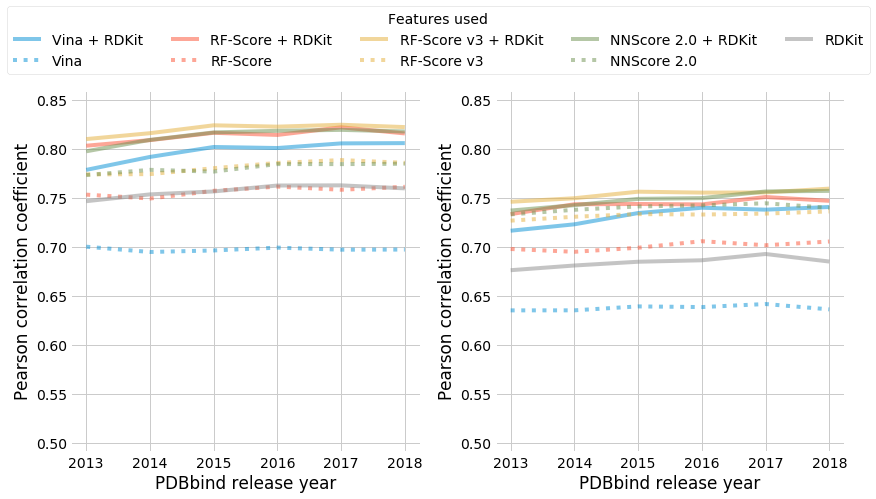

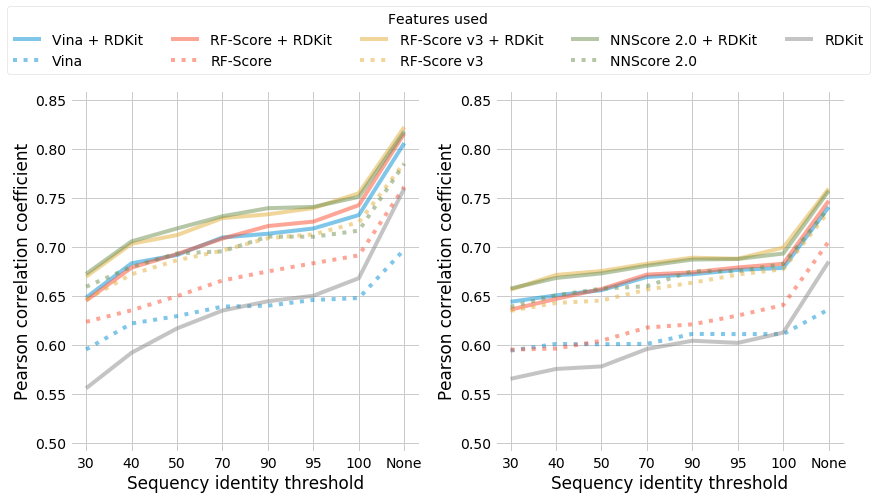

In [21]:
#%%capture
cutoff= 'None'
year = '2018'
core_set = 'all'
data_set = '2018 general'


fig, axes = plt.subplots(1,2, figsize=(12,6))
#axes = axes.flatten()
iteraxes = iter(axes)

# varying year
ax = next(iteraxes)
x = pdbbind_releases
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for sf in scoring_functions:
    colour = next(colours)
    y = rp_by_year[core_set][cutoff].loc[sf + ' + RDKit', general_sets]
    ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_year[core_set][cutoff].loc[sf, general_sets]
    ax.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')

colour = next(colours)
y = rp_by_year[core_set][cutoff].loc['RDKit', general_sets]
ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
ax.set_ylim(0.49, 0.86)
ax.set_xlabel('PDBbind release year')
ax.set_ylabel('Pearson correlation coefficient')

# varying year; similar ligands excluded
ax = next(iteraxes)
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for sf in scoring_functions:
    colour = next(colours)
    y = rp_by_year_lig[core_set][cutoff].loc[sf + ' + RDKit', general_sets]
    ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_year_lig[core_set][cutoff].loc[sf, general_sets]
    ax.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')

colour = next(colours)
y = rp_by_year_lig[core_set][cutoff].loc['RDKit', general_sets]
ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
ax.set_ylim(0.49, 0.86)
ax.set_xlabel('PDBbind release year')
ax.set_ylabel('Pearson correlation coefficient')


fig.tight_layout()
axes[0].legend(loc='upper left', bbox_to_anchor=(-0.2, 1.25),ncol=5, title='Features used')

fig.savefig('/homes/fboyles/varying_year.png', dpi=300, bbox_inches='tight')
    
fig, axes = plt.subplots(1,2, figsize=(12,6))
#axes = axes.flatten()
iteraxes = iter(axes)

# varying SI cutoff
x = blast_cutoffs
ax = next(iteraxes)
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for sf in scoring_functions:
    colour = next(colours)
    y = rp_by_cutoff[core_set][data_set].loc[sf + ' + RDKit', blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_cutoff[core_set][data_set].loc[sf, blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')

colour = next(colours)
y = rp_by_cutoff[core_set][data_set].loc['RDKit', blast_cutoffs]
ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
ax.set_ylim(0.49, 0.86)
ax.set_xlabel('Sequency identity threshold')
ax.set_ylabel('Pearson correlation coefficient')

# varying SI cutoff
x = blast_cutoffs
ax = next(iteraxes)
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for sf in scoring_functions:
    colour = next(colours)
    y = rp_by_cutoff_lig[core_set][data_set].loc[sf + ' + RDKit', blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label=sf + ' + RDKit', color=colour)
    y = rp_by_cutoff_lig[core_set][data_set].loc[sf, blast_cutoffs]
    ax.plot(x, y, alpha=0.5, label=sf, color=colour, linestyle=':')

colour = next(colours)
y = rp_by_cutoff_lig[core_set][data_set].loc['RDKit', blast_cutoffs]
ax.plot(x, y, alpha=0.5, label='RDKit', color=colour)
ax.set_ylim(0.49, 0.86)
ax.set_xlabel('Sequency identity threshold')
ax.set_ylabel('Pearson correlation coefficient')


#for ax, annotation in zip(axes, ['A', 'B', 'C', 'D']):
#    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')

    
fig.tight_layout()
axes[0].legend(loc='upper left', bbox_to_anchor=(-0.2, 1.25),ncol=5, title='Features used')

fig.savefig('/homes/fboyles/varying_cutoff.png', dpi=300, bbox_inches='tight')

#fig.savefig(f'../figures/general_set_summary_plots.jpg', dpi=350, bbox_inches='tight')